In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
df=pd.read_csv("./schedule.csv")
df.head()

,TrainA,TrainB,TrainC,TrainHC
0,14,12,20,-1
1,12,13,9,-1
2,7,18,6,-1
3,16,18,6,-1
4,14,19,10,13


In [3]:
df.describe()

,TrainA,TrainB,TrainC,TrainHC
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,12.499600,12.513200,12.508900,0.861600
std,4.628039,4.609854,4.582665,4.571579
min,5.000000,5.000000,5.000000,-1.000000
25%,8.000000,9.000000,8.000000,-1.000000
50%,13.000000,13.000000,12.000000,-1.000000
75%,17.000000,17.000000,16.000000,-1.000000
max,20.000000,20.000000,20.000000,13.000000


<AxesSubplot:title={'center':'Frequency of Arrival Times for TrainA'}, ylabel='Frequency'>

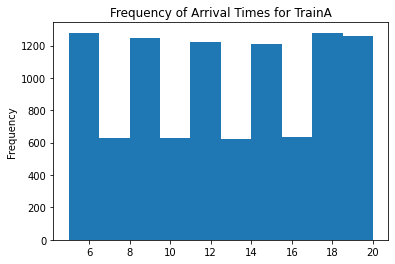

In [4]:
df['TrainA'].plot.hist(title='Frequency of Arrival Times for TrainA')

In [5]:
df['Crews']=''
df['Crew Wages']=''
df['Demurrage Fees']=''
df['Total Cost']=''

In [6]:
# sample=df.loc[0:10000,::]
# sample.head()

### Equations
$$
min(cost+demurrage)
$$
  
$$
cost=mine\_cost+load\_cost
$$
  
$$
\frac{6}{c} (12000c-3000)=mine\_cost
$$
  
$$
\frac{3}{c} (12000c-3000)=load\_cost  
$$
  
$$
demurrage=reg\_demurrage+hc\_demurrage
$$
  
$$
15,000(reg\_trains)(hours)= reg\_demmurage
$$
  
$$
25,000(hc\_train)(hours) = hc\_demmurage  
$$

### Algorithm

##### Normal Weekday Operation (non-Thursday)
Step 1:  
Start with one crew at 0000 on first day.  
If not first iteration, crew will already be working.  
  
Step 2:  
Mine coal until train arrives  

Step 3:  
If a train arrives, assess coal amount{  
If amount>trainload{  
stop loading tipple and load train  
}  
Else{  
call second crew  
load tipple  
}  
}
Else finish loading tipples (up to daily max) until a train arrives  
  
Step 4:  
Continue loading train until full or out of coal  

Step 5:
Once train(s) (is/are) gone, assess coal amount  
If coal> $\frac{1}{2}$ remaining daily load, go to 1 crew and fill tipple up until max daily amount or a train arrives  
Else, use 2 crews to mine to $\frac{1}{2}$ remaining daily load and then drop to 1 crew and fill tipple up until max daily amount or a train arrives  
Repeat 2-5 until last train leaves
  
Step 6:   
Once final train has gone, have one crew fill tipples until next days max is met or until a train arrives  
Repeat from Step 1  
  
##### Thursday Operation
Step 1:  
Start with two crews at 0000.

Step 2:  
Mine coal until train arrives  

Step 3:  
If a train arrives, assess coal amount{  
Check if train is HC  
If HC check coal>2{  
If coal < 2{  
mine
}
Else{  
Load HC
}
}
Else{
If amount>trainload{  
stop loading tipple and load train  
}  
Else{  
call second crew  
load tipple  
}  
}

Step 4:  
Continue loading HC until gone or out of coal  

Step 5:  
Once train(s) (is/are) gone, assess coal amount  
If > $\frac{1}{2}$ remaining daily load, go to 1 crew and fill tipple up until max daily amount or a train arrives  
Else, use 2 crews to mine to $\frac{1}{2}$ remaining daily load and then drop to 1 crew and fill tipple up until max daily amount or a train arrives  
Repeat 2-5 until last train leaves 
  
Step 6:   
Once final train has gone, have one crew fill tipples until daily max is met or until a train arrives  
Repeat from Step 1

tipple= 1.5 trains = 6 hours per crew

train = .66 tipple = 3 hours per crew

mine rate = 6/c / 1.5 train = 4 hours 1 crew mine 1 train, 2 hours 2 crews mine 1 train, 1.33 hours 3 crews mine 1 train

load rate = 3/c = 3 hours 1 crew, .66 hour 2 crews, 1 hour 3 crews

In [7]:
def mine_cost(crews):
    return ((12000*crews)-3000)

def mine_rate(crews):
    return .25*crews

def load_cost(crews):
    return ((12000*crews)-3000)

def load_rate(crews):
    return .33*crews

def demurrage_cost(trains):
    return ((trains[0]*15000)+(trains[1]*25000))

In [8]:
coal=load=0

for x in range(0,len(df)):
    loads=hc_load=daily_loads=crew_cost=demurrage=0
    a=df.loc[x,'TrainA']
    b=df.loc[x,'TrainB']
    c=df.loc[x,'TrainC']
    hc=df.loc[x,'TrainHC']
    
    crews=1
    max_crews=1
    
    trains=[a,b,c,hc]
    arrived=[]
    departed=[]
    demurrage_rate=[0,0]
    trains=np.sort(trains)

    if x%7==4:
        max_loads=5
    else:
        max_loads=3
        # Get rid of placeholder value for TrainHC
        trains=np.delete(trains,0)
        
    for i in range(0,24):
        #print(crew_cost,coal,arrived,departed,demurrage)
        # A train has arrived, add it to the list of arrivals
        if i in trains:
            arrived.append(i)
            #print(i, "arrives")
            
            # Check to see if train is HC
            if i==hc:
                #print("is high capacity")
                # Check to see if other trains are still being loaded
                crews=2
                max_crews=2
                # Not enough coal for HC
                if coal+hc_load<2:
                    #print("need coal")
                    # Mine more and set hc demurrage flag to 1
                    demurrage_rate[1]=1
                    coal+=mine_rate(crews)
                    crew_cost+=mine_cost(crews)
                    demurrage+=demurrage_cost(demurrage_rate)
                # Enough coal for HC, start loading
                else:
                    #print("have coal, loading")
                    hc_load+=load_rate(crews)
                    coal-=load_rate(crews)
                    crew_cost+=load_cost(crews)
                    if demurrage_rate[0]>0:
                        demurrage+=demurrage_cost(demurrage_rate)
                    
                    if hc_load>=2:
                        #print("hc loaded")
                        departed.append(hc)
                        #print("added hc to departed",departed)
                        arrived.remove(hc)
                        #print("removed hc from departed" ,arrived)
                        coal+=hc_load-2
                        demurrage_rate[1]=0
            
            # Not HC train
            else:
                #print("not high capacity")
                # More than 1 train is in, add demurrage and keep loading
                if (len(arrived)>1):
                    #print("not only train in queue")
                    # More then one train waiting to be loaded
                    crews=2
                    max_crews=2
                    # HC train check
                    if hc in arrived and hc not in departed:
                        #print("other train high capacity")
                        # Not enough coal for HC
                        if coal+hc_load<2:
                            #print("need more coal")
                            # Mine more and set hc demurrage flag to 1
                            demurrage_rate[1]=1
                            crew_cost+=mine_cost(crews)
                            coal+=mine_rate(crews)
                            demurrage+=demurrage_cost(demurrage_rate)
                        # Enough coal for HC, start loading
                        else:
                            #print("loading high capacity")
                            hc_load+=load_rate(crews)
                            coal-=load_rate(crews)
                            crew_cost+=load_cost(crews)
                            if demurrage_rate[0]>0:
                                demurrage+=demurrage_cost(demurrage_rate)

                            if hc_load>=2:
                                #print("hc full")
                                departed.append(hc)
                                #print("added hc to departed",departed)
                                arrived.remove(hc)
                                #print("removed hc from departed" ,arrived)
                                coal+=hc_load-2
                                demurrage_rate[1]=0
                                
                    # HC not waiting
                    else:
                        #print("train not high capacity")
                        if coal+load<1:
                            #print("not enough coal")
                            demurrage_rate[0]+=(len(arrived))
                            demurrage+=demurrage_cost(demurrage_rate)
                            coal+=mine_rate(crews)
                            crew_cost+=mine_cost(crews)
                        else:
                            #print("loading train")
                            if demurrage_rate[0]>0:
                                demurrage+=demurrage_cost(demurrage_rate)
                            load+=load_rate(crews)
                            coal-=load_rate(crews)
                            crew_cost+=load_cost(crews)
                            
                            if load>=1:
                                #print("train full")
                                departed.append(min(arrived))
                                arrived.remove(min(arrived))
                                #print("departed", departed, "arrived", arrived)
                                coal+=load-1
                                if demurrage_rate[0]>=1:
                                    demurrage_rate[0]-=1
                                load=0
                            
                # Only one train to load
                else:
                    #print("only train")
                    crews=1
                    if coal+load<1:
                        #print("getting more coal")
                        crews=2
                        max_crews=2
                        demurrage_rate[0]+=(len(arrived))
                        demurrage+=demurrage_cost(demurrage_rate)
                        coal+=mine_rate(crews)
                        crew_cost+=mine_cost(crews)
                    else:
                        #print("loading")
                        if demurrage_rate[0]>0:
                                demurrage+=demurrage_cost(demurrage_rate)
                        load+=load_rate(crews)
                        coal-=load_rate(crews)
                        crew_cost+=load_cost(crews)
                        if demurrage_rate[0]>=1:
                            demurrage_rate[0]-=1
                            demurrage+=demurrage_cost(demurrage_rate)
                        if load>=1:
                            departed.append(min(arrived))
                            arrived.remove(min(arrived))
                            #print("departed", departed, "arrived", arrived)
                            coal+=load-1
                            load=0
                       
        # No new trains have arrived
        else:
            #print("No new trains this hour")
            # Check status of arrived trains
            if arrived:
                #print("train already in queue")
                # Train exists, check HC status
                if hc in arrived and hc not in departed:
                    #print("is high capacity, doubling crews")
                    crews=2
                    max_crews=2
                    # Not enough coal for HC
                    if coal+hc_load<2:
                        #print("need more coal")
                        # Mine more and set hc demurrage flag to 1
                        demurrage_rate[0]=(len(arrived)-1)
                        demurrage_rate[1]=1
                        crew_cost+=mine_cost(crews)
                        coal+=mine_rate(crews)
                        demurrage+=demurrage_cost(demurrage_rate)
                    # Enough coal for HC, start loading
                    else:
                        #print("loading high capacity")
                        hc_load+=load_rate(crews)
                        coal-=load_rate(crews)
                        crew_cost+=load_cost(crews)
                        demurrage_rate[0]=(len(arrived)-1)
                        demurrage+=demurrage_cost(demurrage_rate)
                        if hc_load>=2:
                            #print("hc loaded")
                            if demurrage_rate[0]>=1:
                                demurrage_rate[0]-=1
                            departed.append(hc)
                            #print("added hc to departed",departed)
                            arrived.remove(hc)
                            #print("removed hc from departed" ,arrived)
                            coal+=hc_load-2
                            demurrage_rate[1]=0
                                
                # HC not waiting
                else:
                    #print("normal train waiting")
                    if coal+load<1:
                        #print("not enough coal")
                        crews=2
                        max_crews=2
                        demurrage_rate[0]=(len(arrived))
                        demurrage+=demurrage_cost(demurrage_rate)
                        coal+=mine_rate(crews)
                        crew_cost+=mine_cost(crews)
                    else:
                        #print("loading train")
                        demurrage_rate[0]=(len(arrived)-1)
                        demurrage+=demurrage_cost(demurrage_rate)
                        load+=load_rate(crews)
                        coal-=load_rate(crews)
                        crew_cost+=load_cost(crews)
 
                        if load>=1:
                            #print("train full")
                            if demurrage_rate[0]>=1:
                                demurrage_rate[0]-=1 
                            departed.append(min(arrived))
                            arrived.remove(min(arrived))
                            #print("departed", departed, "arrived", arrived)
                            coal+=load-1
                            load=0
                    
            # If none, keep mining
            else:
                crews=1
                if coal<max_loads:
                    coal+=mine_rate(crews)
                    crew_cost+=mine_cost(crews)
                    
    df.loc[x,'Crews']=max_crews
    df.loc[x,'Crew Wages']=crew_cost
    df.loc[x,'Demurrage Fees']=demurrage
    df.loc[x,'Total Cost']=(crew_cost+demurrage)

In [9]:
df.head()

,TrainA,TrainB,TrainC,TrainHC,Crews,Crew Wages,Demurrage Fees,Total Cost
0,14,12,20,-1,2,252000,0,252000
1,12,13,9,-1,2,288000,30000,318000
2,7,18,6,-1,2,255000,15000,270000
3,16,18,6,-1,2,207000,0,207000
4,14,19,10,13,2,348000,105000,453000


In [10]:
weekly=0
weekly_record=[]
for x in range(0,len(df['Total Cost'])):
    if x%7!=0:
        weekly+=df.loc[x,'Total Cost']
    else:
        weekly_record.append(weekly)
        weekly=0
        weekly+=df.loc[x,'Total Cost']

In [11]:
weekly=pd.DataFrame(data=weekly_record, columns=['Weekly Demurrage'])

In [12]:
weekly.head()

,Weekly Demurrage
0,0
1,1995000
2,1776000
3,1767000
4,2080000


In [13]:
monthly_demurrage=0
months=[31,28,31,30,31,30,31,31,30,31,30,31]
month=0
count=0
demurrage_tracker=[]

for x in range(0,len(df['Total Cost'])):
    if count==months[month]:
        demurrage_tracker.append(monthly_demurrage)
        count=0
        monthly_demurrage=0
        if month==11:
            month=0
        else:
            month+=1    
    else:
        monthly_demurrage+=df.loc[x,'Demurrage Fees']
        count+=1

In [14]:
monthly=pd.DataFrame(data=demurrage_tracker, columns=['Monthly Demurrage'])

In [15]:
monthly.head()

,Monthly Demurrage
0,685000
1,705000
2,450000
3,1015000
4,970000


In [18]:
monthly.describe()

,Monthly Demurrage
count,3.180000e+02
mean,8.584906e+05
std,2.311985e+05
min,3.000000e+05
25%,6.912500e+05
50%,8.500000e+05
75%,1.005000e+06
max,1.545000e+06


In [16]:
monthly.mean()

Monthly Demurrage    858490.566038
dtype: float64

In [17]:
df.to_csv("./output.csv")